# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using BAT 

# Load Data

In [4]:
function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [ ]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 9

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

## 1.2 High `p` Population: 

In [43]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


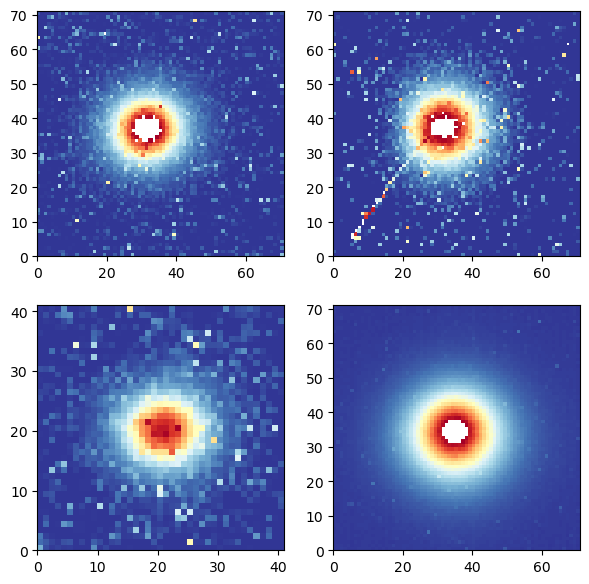

PyObject <matplotlib.collections.QuadMesh object at 0x7f22d8de4d60>

In [44]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [ ]:
# include("../src/model-35/likelihood.jl")
# include("../src/model-35/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# flat prior for the pixel size
# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.02, 0.20), truncated(Normal(0.2, 0.04), 0.02, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
#     waist = [Normal(2.9, 0.03)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
#     psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
#     psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
#     cam4_psx = truncated(Normal(121.8, 121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
#     cam4_psy = truncated(Normal(120.0, 120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ); 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.02, 0.20), truncated(Normal(0.2, 0.04), 0.02, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
#     waist = [Normal(2.9, 0.03)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ); 

## Model 38: 

In [ ]:
# include("../src/model-38/likelihood.jl")
# include("../src/model-38/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.20), truncated(Normal(0.2, 0.04), 0.06, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

## Model 41: 

In [45]:
include("../src/model-41/likelihood.jl")
include("../src/model-41/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [46]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );



# MCMC settings: 

In [47]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#168 (generic function with 1 method)

In [48]:
# posterior = PosteriorDensity(log_likelihood, prior)

# tuning = AdaptiveMHTuning(
#     λ = 0.5,
#     α = ClosedInterval(0.15,0.25),
#     β = 1.5,
#     c = ClosedInterval(1e-4,1e2),
#     r = 0.5,
# )

# convergence = BrooksGelmanConvergence(
#     threshold = 1.1,
#     corrected = false
# )

# init = MCMCChainPoolInit(
#     init_tries_per_chain = ClosedInterval(50,150),
#     max_nsamples_init = 500,
#     max_nsteps_init = 500,
#     max_time_init = Inf
# )

# burnin = MCMCMultiCycleBurnin(
#     max_nsamples_per_cycle = 10000,
#     max_nsteps_per_cycle = 10000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 130
# )

# nsamples = 4*10^5
# nchains = 4

# sampler = MetropolisHastings(tuning=tuning,)

# algorithm = MCMCSampling(sampler=sampler, 
#     nchains=nchains, 
#     init=init, 
#     burnin=burnin, 
#     convergence=convergence
# );


posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
     nsteps_init = 500,
)

burnin = MCMCMultiCycleBurnin(
    nsteps_per_cycle = 10000,
    max_ncycles = 130
)

nsamples = 4*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nsteps=nsamples, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [49]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [50]:
@time samples_tot = bat_sample(
    posterior, algorithm);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm PriorSubstitution()
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/chain_pool_init.jl:48
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/chain_pool_init.jl:166
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:27
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:57
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:57
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 c

1993.391955 seconds (4.35 G allocations: 3.922 TiB, 14.92% gc time)


In [53]:
samples = samples_tot.result;

In [54]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

2.919794549017259

In [55]:
size(flatview(unshaped.(samples.v)))

(27, 338867)

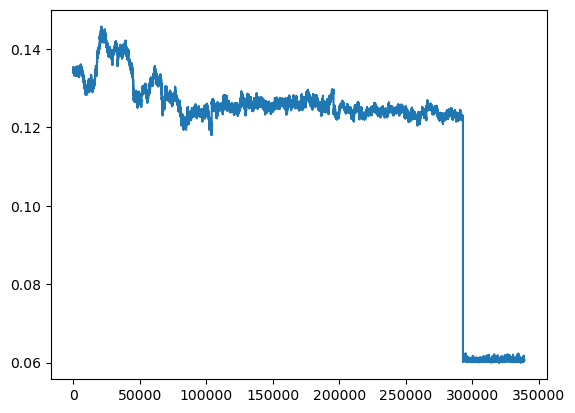

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d8d720a0>

In [56]:
plot(flatview(unshaped.(samples.v))[3,:])

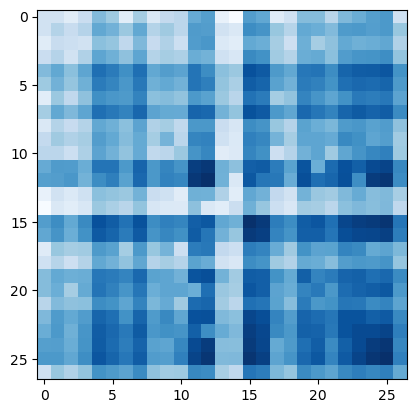

PyObject <matplotlib.image.AxesImage object at 0x7f22d8d5ec70>

In [57]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [58]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/Benchmark-8/samples-41.hdf5", unshaped.(samples))

In [59]:
#  27.1, 21.6, 114.0, 30.5, 23.4, 125.0, 121.8, 120.0

In [60]:
mode(samples)[1]

(tr_size = [0.08760269569280672, 0.135337605520007], tr_size_2 = [0.12530268750293633, 0.16764047221744335], ang_spr = [6.999999999992209, 5.815843317966282], ang_spr_2 = [3.3044711147573333, 1.002913417706861], mixt_pow = 0.5862047322372487, waist = [2.983001375721276], waist_2 = [2.7902147773366868], algmx = [31.734600689797368, 32.23126989886475, 21.295362937240316, 35.2379162393189], algmy = [36.930064392371456, 37.42767484769739, 20.25824510436856, 33.93457567858015], cam4_ped = 24.047245596042767, cam4_light_fluct = 1.3123738915794114, cam4_light_amp = 9.052577455302746, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 3.902002378146918, cam4_resy = 6.216274199863606, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.541027871783992, 11.370307606573817, 2.1706449870526026], s_cam = [0.0, 1.478, 15.026, 23.115])

In [61]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.05975, 0.1895], tr_size_2 = [0.06025, 0.0595], ang_spr = [6.99, 6.995], ang_spr_2 = [3.9975, 1.01], mixt_pow = 0.5045, waist = [2.649], waist_2 = [2.6494999999999997], algmx = [31.75, 32.25, 21.319000000000003, 35.2315], algmy = [36.95, 37.45, 20.192500000000003, 33.909499999999994], cam4_ped = 26.325000000000003, cam4_light_fluct = 3.005, cam4_light_amp = 9.905000000000001, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = -0.025, cam4_resy = -0.025, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [1.025, 1.025, 2.1775], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [62]:
mean(samples)[1]

(tr_size = [0.07831864396949452, 0.1334719712323485], tr_size_2 = [0.11035006519834749, 0.13555449778025808], ang_spr = [6.4312340246696165, 6.140910368149154], ang_spr_2 = [3.739670601063657, 2.157070809752511], mixt_pow = 0.5753077565032642, waist = [2.840756813077984], waist_2 = [2.72195209476945], algmx = [34.505355723623026, 37.10667266778289, 21.311841699833227, 35.23819325265308], algmy = [39.95960304009892, 35.90565457941257, 20.374580259308008, 33.892448034968325], cam4_ped = 24.66623471116927, cam4_light_fluct = 1.856876943516115, cam4_light_amp = 9.1365144913207, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 3.1759024943605967, cam4_resy = 4.140213313307269, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [4.747758900041692, 6.1958653196920945, 2.3590593047339934], s_cam = [0.0, 1.478, 15.026, 23.115])

In [63]:
std(samples)[1]

(tr_size = [0.019778661575044088, 0.045027180727396414], tr_size_2 = [0.02905052942088159, 0.04378059880425691], ang_spr = [0.910987455723192, 0.5263737116703131], ang_spr_2 = [0.29088807637326575, 1.2009884746855994], mixt_pow = 0.050580755678046194, waist = [0.14910275410905127], waist_2 = [0.072111320945306], algmx = [4.437217813103168, 6.492495300850254, 0.047138986644619095, 0.02296105596261122], algmy = [4.664689855383659, 3.2616402712451764, 0.19998293265453365, 0.043680093416347404], cam4_ped = 1.6700292601388582, cam4_light_fluct = 0.6803457081887061, cam4_light_amp = 0.4554660512127057, resx = 3-element Fill{Int64}: entries equal to 0, resy = 3-element Fill{Int64}: entries equal to 0, cam4_resx = 2.259785027162479, cam4_resy = 2.4565952347332622, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [3.7479283732755535, 5.1960087940939585, 0.18899972859133551], s_cam = 4-element Fi

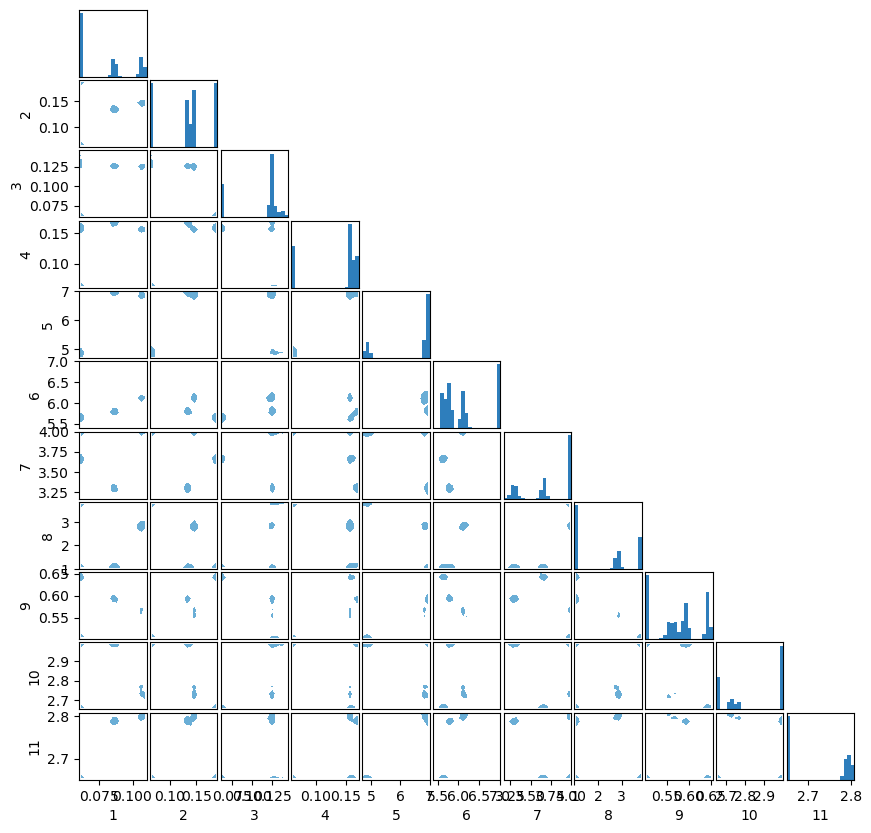

In [64]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

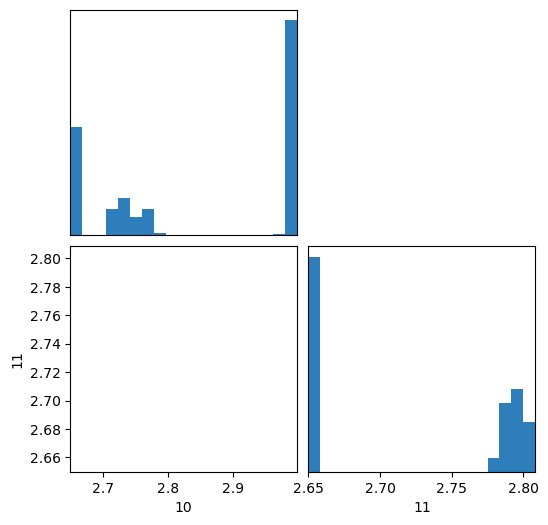

In [65]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [66]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /user/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6345, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 822, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1419, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1490, in _contour_args
    self._contour_level_args(z, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1174, in _contour_level_args
    raise ValueError("Contour levels must be increasing")


In [67]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /user/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6345, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 822, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1419, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1490, in _contour_args
    self._contour_level_args(z, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py", line 1174, in _contour_level_args
    raise ValueError("Contour levels must be increasing")


In [68]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×338867 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [28, 1:338867]

In [69]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×338867 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [33, 1:338867]

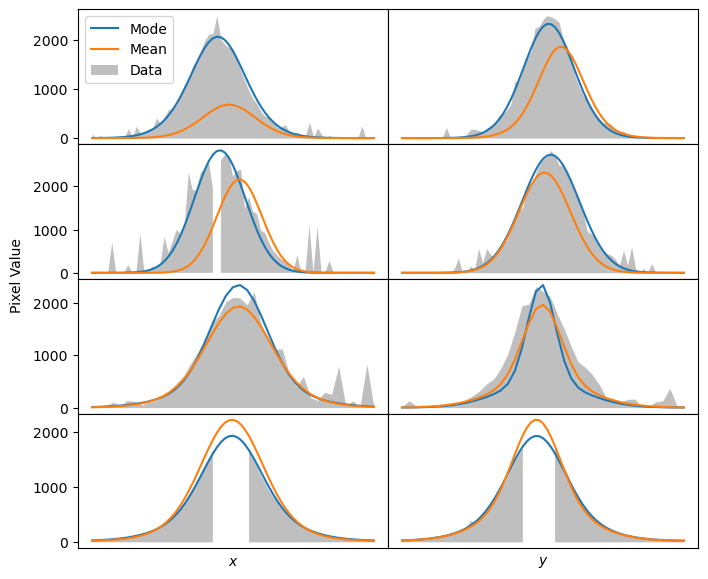

PyObject Text(0.04, 0.5, 'Pixel Value')

In [70]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

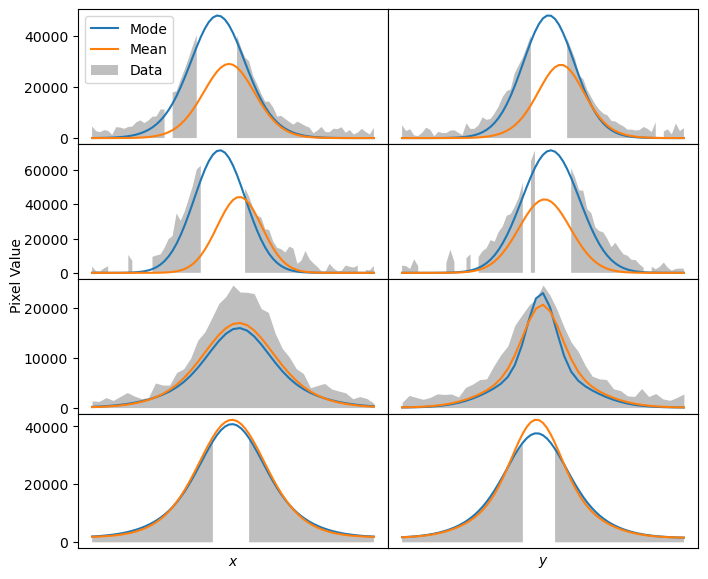

PyObject Text(0.04, 0.5, 'Pixel Value')

In [71]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

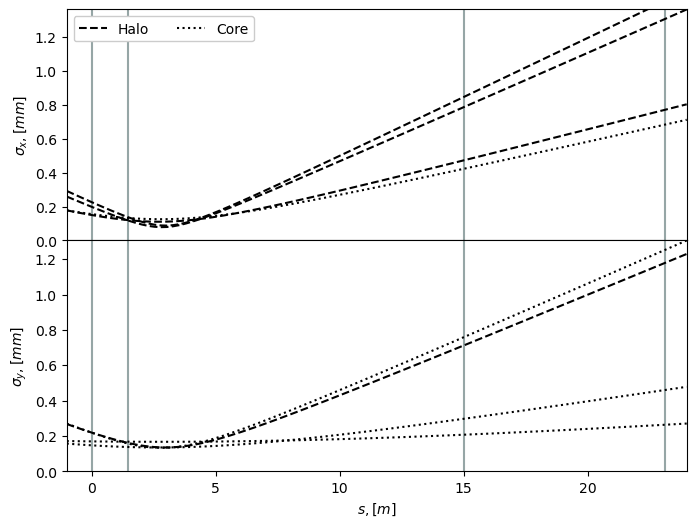

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [72]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [73]:
images = load("../data/experiment/dataset_2/m2/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

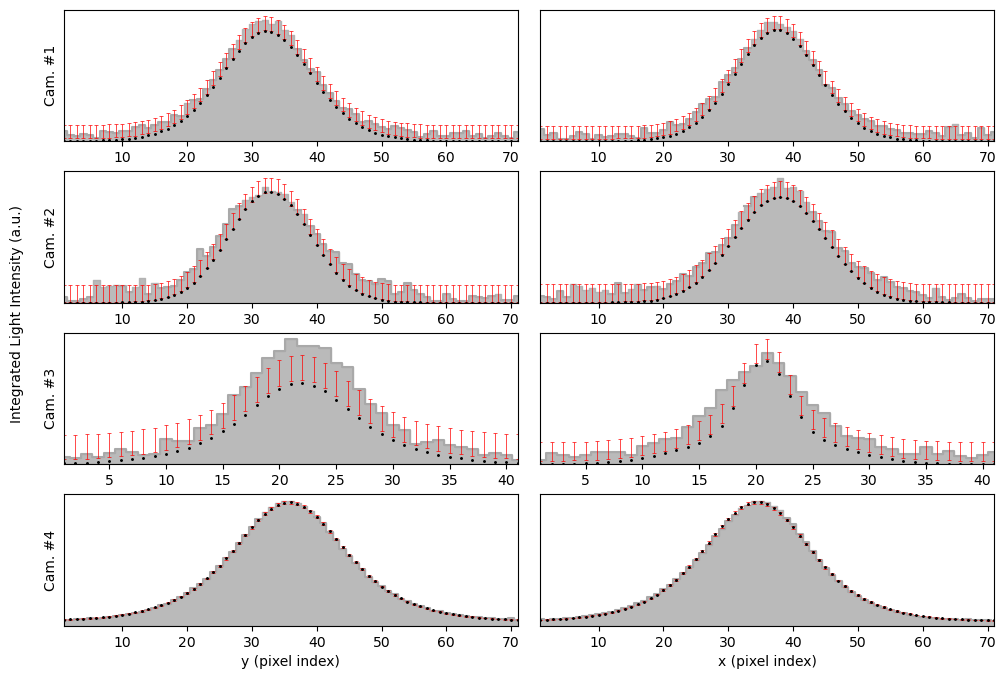

PyObject Text(0.08, 0.5, 'Integrated Light Intensity (a.u.)')

In [74]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [75]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera